# PROYECTO: MODELO DE RIESGO

- María José Castillo Silva
- Juan David Bocanegra Vargas

In [1]:
# Permite ajustar la anchura de la parte útil de la libreta (reduce los márgenes) y omitir warnings
import warnings; warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML
display(HTML("<style>.container{ width:98% }</style>"))

# 1. Problema a Analizar

# ¿Cuál es la probabilidad de riesgo de default asociada a cada cliente, dadas sus diferentes características?.

La principal fuente de datos es Datacredito Experian, quienes envían información de los clientes actuales de la Entidad, incluyendo las siguientes variables: “Acierta Advance”, score de crédito del sector financiero, saldos, estados de productos crediticios y también información demografica como edad, sexo, entre otras.

# 2. Impacto del Problema

Actualmente en las áreas de riesgo de crédito en el sector bancario, se definen constantemente políticas que permiten soportar la toma de decisiones en la originación  de productos, que en la medida de lo posible, estén enmarcadas en la agilidad y precisión de la respuesta a clientes, y vayan en línea con el apetito financiero propuesto por la Junta Directiva.

# 3. Datos, primer análisis exploratorio

## Instalación de Librerias

In [2]:
#!pip install eli5
#!pip install pandas
#!pip install numpy
#!pip install seaborn
#!pip install yellowbrick
#!pip install xgboost
#!pip install shap
#!pip install matplotlib
#!pip install scikit-learn
#!pip install imbalanced-learn

  Using cached scikit_learn-1.7.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
Using cached scikit_learn-1.7.2-cp312-cp312-win_amd64.whl (8.7 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2


## Cargar Librerías

In [3]:
%pip install -U scikit-learn==1.5.2 imbalanced-learn==0.12.3 yellowbrick==1.5


  Using cached scikit_learn-1.5.2-cp312-cp312-win_amd64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp312-cp312-win_amd64.whl (11.0 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.2
    Uninstalling scikit-learn-1.7.2:
      Successfully uninstalled scikit-learn-1.7.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
eli5 0.16.0 requires scikit-learn>=1.6.0, but you have scikit-learn 1.5.2 which is incompatible.


In [4]:
# ===============================
# Núcleo científico / utilidades
# ===============================
import warnings; warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===============================
# Modelado y validación (scikit-learn)
# ===============================
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# ===============================
# Desbalanceo de clases (imbalanced-learn)
# ===============================
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# ===============================
# Gradient Boosting (XGBoost)
# ===============================
from xgboost import XGBClassifier

# ===============================
# Estadística (SciPy y Statsmodels)
# ===============================
from scipy import stats
from scipy.stats import shapiro, normaltest, ttest_ind, mannwhitneyu
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor  # VIF

# ===============================
# Otros apoyos
# ===============================
from collections import Counter

# ===============================
# Opcionales de interpretación/visual
# ===============================
import shap
from yellowbrick.classifier import ROCAUC, ConfusionMatrix, ClassificationReport
import eli5

# ===============================
# Estilo de gráficos
# ===============================
plt.style.use("ggplot")


## Importar Datos

In [ ]:
datos = pd.read_csv('base_modelo_40k.csv', sep=',')
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   40000 non-null  int64  
 1   CLIENTE_MORA         40000 non-null  int64  
 2   SEXO                 40000 non-null  object 
 3   EDAD                 40000 non-null  int64  
 4   INGRESO              40000 non-null  float64
 5   SCORE_DATACREDITO    40000 non-null  int64  
 6   CRED_REESTRUCTURADO  40000 non-null  int64  
 7   ANT_SF               40000 non-null  float64
 8   SALDO_SF             40000 non-null  float64
 9   TIENE_HIPOTECA       40000 non-null  int64  
 10  ULTIMAPERTURA        40000 non-null  int64  
 11  SALDO_FIJO           40000 non-null  float64
 12  SALDO_ROT            40000 non-null  float64
 13  ESTADO_MORA_FIN      40000 non-null  float64
 14  ESTADO_MORA_REAL     40000 non-null  float64
dtypes: float64(7), int64(7), object(1)
m

In [6]:
datos

,ID,CLIENTE_MORA,SEXO,EDAD,INGRESO,SCORE_DATACREDITO,CRED_REESTRUCTURADO,ANT_SF,SALDO_SF,TIENE_HIPOTECA,ULTIMAPERTURA,SALDO_FIJO,SALDO_ROT,ESTADO_MORA_FIN,ESTADO_MORA_REAL
0,245411,0,F,51,5.373539,675,0,6.83,133.124423,0,35,86.191899,68.093088,0.0,0.0
1,278521,0,M,32,20.009334,812,0,7.83,282.607212,0,18,68.242921,19.081655,0.0,0.0
2,58481,0,M,58,5.537541,812,0,6.17,10.650218,0,3,26.764786,44.264709,0.0,0.0
3,183771,0,F,40,5.838028,840,0,7.00,87.428428,1,7,32.291321,29.558226,0.0,0.0
4,310611,0,M,63,2.192562,625,0,0.00,0.000000,0,-1,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,11301,0,F,60,5.855639,753,0,7.75,46.270552,0,5,91.765247,58.386919,0.0,0.0
39996,302581,0,F,57,2.975149,725,0,6.08,6.774709,0,56,73.974337,68.846599,0.0,0.0
39997,328851,0,M,38,3.473759,753,0,12.00,3.549705,0,27,51.626281,21.191923,0.0,0.0
39998,143341,1,M,54,7.497859,625,0,22.00,52.590679,0,9,73.950412,79.353979,0.0,0.0


In [7]:
print(datos.shape)

(40000, 15)


* Inicialmente se contemplaron 40 variables en estudio, mixtas entre categóricas y numéricas

## Limpieza y Armonización

In [8]:
### CONVERSIÓN TIPOS DE FORMATO
datos['CRED_REESTRUCTURADO']=datos['CRED_REESTRUCTURADO'].astype('object')
datos['TIENE_HIPOTECA']=datos['TIENE_HIPOTECA'].astype('object')

In [9]:
### Conteo valores nulos
datos.isnull().sum()

ID                     0
CLIENTE_MORA           0
SEXO                   0
EDAD                   0
INGRESO                0
SCORE_DATACREDITO      0
CRED_REESTRUCTURADO    0
ANT_SF                 0
SALDO_SF               0
TIENE_HIPOTECA         0
ULTIMAPERTURA          0
SALDO_FIJO             0
SALDO_ROT              0
ESTADO_MORA_FIN        0
ESTADO_MORA_REAL       0
dtype: int64

* Por criterio experto, se consideran no necesarias las variables asociadas a la identificación del cliente, como el tipo de Id, el número de identificación y la fecha de evaluación; también se elimina la variable "Acierta_plus" ya que existe la variable "Advance".

In [10]:
#ELIMINAR COLUMNAS NO NECESARIAS
datos=datos.drop(labels='ID',axis=1)
datos

,CLIENTE_MORA,SEXO,EDAD,INGRESO,SCORE_DATACREDITO,CRED_REESTRUCTURADO,ANT_SF,SALDO_SF,TIENE_HIPOTECA,ULTIMAPERTURA,SALDO_FIJO,SALDO_ROT,ESTADO_MORA_FIN,ESTADO_MORA_REAL
0,0,F,51,5.373539,675,0,6.83,133.124423,0,35,86.191899,68.093088,0.0,0.0
1,0,M,32,20.009334,812,0,7.83,282.607212,0,18,68.242921,19.081655,0.0,0.0
2,0,M,58,5.537541,812,0,6.17,10.650218,0,3,26.764786,44.264709,0.0,0.0
3,0,F,40,5.838028,840,0,7.00,87.428428,1,7,32.291321,29.558226,0.0,0.0
4,0,M,63,2.192562,625,0,0.00,0.000000,0,-1,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0,F,60,5.855639,753,0,7.75,46.270552,0,5,91.765247,58.386919,0.0,0.0
39996,0,F,57,2.975149,725,0,6.08,6.774709,0,56,73.974337,68.846599,0.0,0.0
39997,0,M,38,3.473759,753,0,12.00,3.549705,0,27,51.626281,21.191923,0.0,0.0
39998,1,M,54,7.497859,625,0,22.00,52.590679,0,9,73.950412,79.353979,0.0,0.0


In [11]:
### Dimensión base de datos
print(datos.shape)

(40000, 14)


## Análisis Exploratorio

* La Variable de interés es la variable llamada VAR_DEP, que es 1 si el cliente tuvo una mora mayor a 90 días en los doce meses siguientes al desembolso del credito y 0 si ha estado al día.

In [12]:
### Proporción de clientes en Mora
datos.groupby('CLIENTE_MORA').size()/datos['CLIENTE_MORA'].count()*100

CLIENTE_MORA
0    92.1375
1     7.8625
dtype: float64

* La base con 54.759 clientes, contiene un 7.08% de clientes en mora y un 92.92% de clientes al día

Text(0.5, 1.0, 'Score Datacredito Clientes al día y en mora')

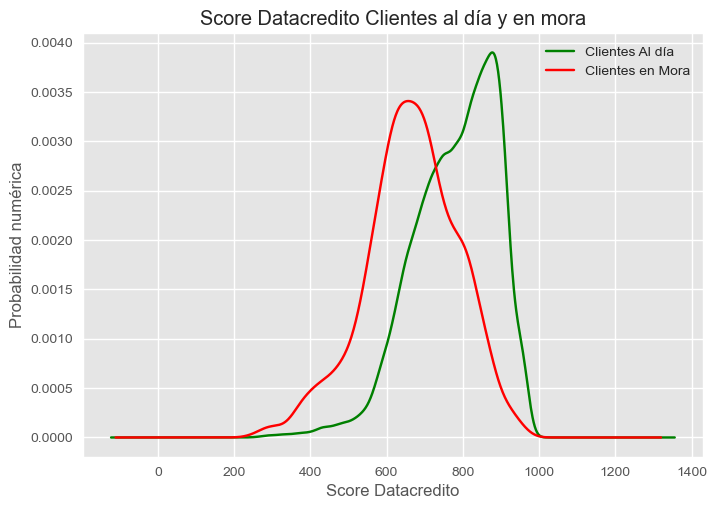

In [13]:
#Separación de Bases
datos_0 = datos[datos['CLIENTE_MORA'] == 0]
datos_1 = datos[datos['CLIENTE_MORA'] == 1]

#Función de densidad 
datos_0.SCORE_DATACREDITO.plot.density(color='green',label='Clientes Al día') 
datos_1.SCORE_DATACREDITO.plot.density(color='red',label='Clientes en Mora')
plt.legend()
plt.xlabel("Score Datacredito")
plt.ylabel('Probabilidad numérica')
plt.title('Score Datacredito Clientes al día y en mora')

* Se evidencia que los clientes que han tenido una mora de 90 días o más en los 12 ultimos meses tienen un Score Advance (cálculo por datacredito) menor a los clientes que han estado al día. También se resalta que, la mayoría de clientes en mora tienen un Score Advance entre 500 a 850, en cambio los clientes que han estado al día tienen un score adnvance entre 650 a 950.

### Pruebas estadísticas

In [14]:
# Test de normalidad Shapiro-Wilk
print("Prueba Shapiro-Wilk Población al día:",shapiro(datos_0['SCORE_DATACREDITO']))
print("Prueba Shapiro-Wilk Población en mora:",shapiro(datos_1['SCORE_DATACREDITO']))

Prueba Shapiro-Wilk Población al día: ShapiroResult(statistic=0.9604629152610893, pvalue=3.497891665963961e-69)
Prueba Shapiro-Wilk Población en mora: ShapiroResult(statistic=0.9901863098442275, pvalue=6.594495942150208e-14)


In [15]:
# Diferencia de medias
def dif_medias (df1, df2, alfa):
    stat, p = ttest_ind(df1,df2, equal_var = False)
    print("Statistic=%.3f, p=%.3f" % (stat,p))

dif_medias (datos_0['SCORE_DATACREDITO'], datos_1['SCORE_DATACREDITO'], 0.05)

Statistic=51.261, p=0.000


In [16]:
# Prueba no parametrcia Mann-Whitney para comparar la variable ADVANCE en los dos grupos
stat, p = mannwhitneyu(datos_0['SCORE_DATACREDITO'], datos_1['SCORE_DATACREDITO'], alternative='two-sided')

print("Mann-Whitney U Test")
print(f"Estadístico U = {stat:.3f}, p-valor = {p:.3e}")

# Interpretación rápida
alpha = 0.05
if p < alpha:
    print("👉 Se rechaza H0: Las distribuciones de ADVANCE en los dos grupos son diferentes.")
else:
    print("👉 No se rechaza H0: No hay evidencia de diferencia significativa entre los grupos.")

Mann-Whitney U Test
Estadístico U = 88669802.000, p-valor = 0.000e+00
👉 Se rechaza H0: Las distribuciones de ADVANCE en los dos grupos son diferentes.


* Existe evidencia estadísticamente significativa para afirmar que las medias de la variable ADVANCE en los dos grupos comparados (datos_0 y datos_1) son diferentes.

Text(0.5, 1.0, 'Antigüedad Financiera de Clientes al día y en mora')

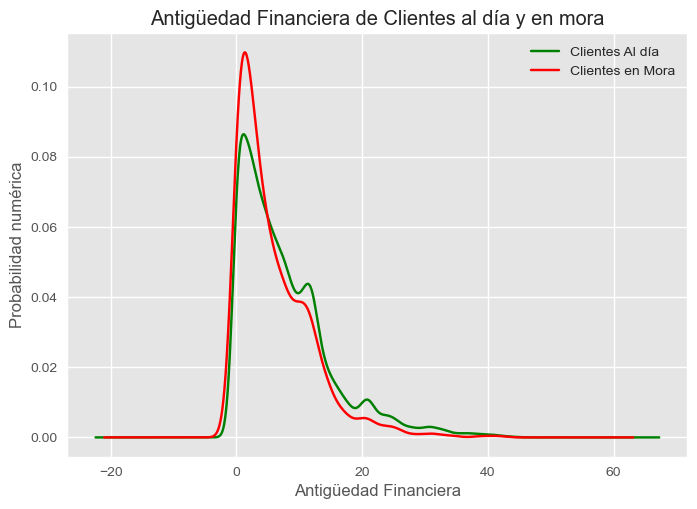

In [17]:
datos_0.ANT_SF.plot.density(color='green',label='Clientes Al día') 
datos_1.ANT_SF.plot.density(color='red',label='Clientes en Mora')
plt.legend()
plt.xlabel("Antigüedad Financiera")
plt.ylabel('Probabilidad numérica')
plt.title('Antigüedad Financiera de Clientes al día y en mora')

* Se evidencia como lo clientes que estan al día tienden  a tener mayor antiguedad en el sector financiero a comparación de los cliente en mora.

In [18]:
# prueba K-S
stats.ks_2samp(datos_0['ANT_SF'], datos_1['ANT_SF'])

KstestResult(statistic=0.11398107868696111, pvalue=2.9720346467054946e-33, statistic_location=4.83, statistic_sign=-1)

👉 Los clientes al día tienden a tener una mayor antigüedad en el sistema financiero que los clientes en mora.

Text(0.5, 1.0, 'Edad Clientes al día y en mora')

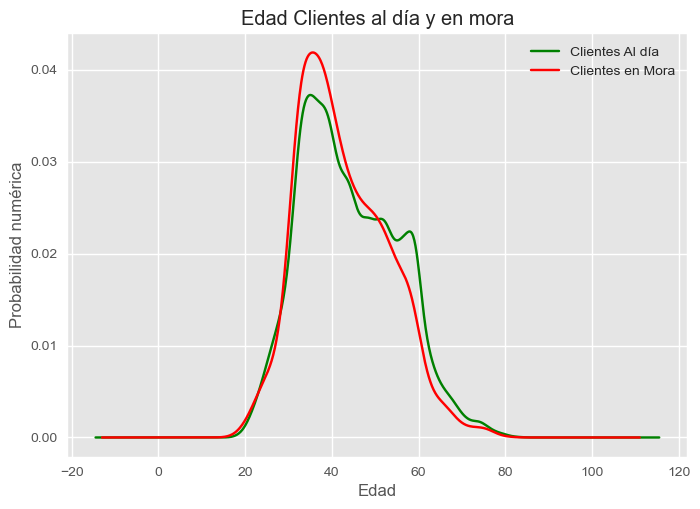

In [19]:
datos_0.EDAD.plot.density(color='green',label='Clientes Al día') 
datos_1.EDAD.plot.density(color='red',label='Clientes en Mora')
plt.legend()
plt.xlabel("Edad")
plt.ylabel('Probabilidad numérica')
plt.title('Edad Clientes al día y en mora')

* Los clientes en mora tienden a concentrarse en edades entre los 30 a los 40 años, en cambio los clientes al día tienden a ser de mayor edad.

In [20]:
pd.crosstab(datos['SEXO'], datos['CLIENTE_MORA'], normalize='index')*100

CLIENTE_MORA,0,1
SEXO,,
F,92.618683,7.381317
M,91.675649,8.324351


* Se evidencia que las mujeres pagan mejor que los hombres, dado que el porcentaje de incumplimiento de las mujeres es 6.7% en cambio de los hombres es de 7.5%.

Text(0.5, 1.0, 'Ingresos de Clientes al día y en mora')

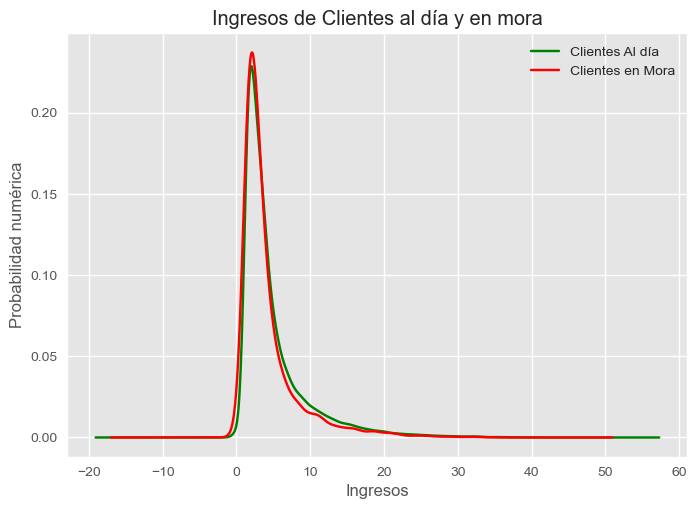

In [21]:
datos_0.INGRESO.plot.density(color='green',label='Clientes Al día') 
datos_1.INGRESO.plot.density(color='red',label='Clientes en Mora')
plt.legend()
plt.xlabel("Ingresos")
plt.ylabel('Probabilidad numérica')
plt.title('Ingresos de Clientes al día y en mora')

* Se evidencia que no existen diferencias de ingreso respecto al incumplimiento de pago de los clientes.

Text(0.5, 1.0, 'Ingresos de Clientes al día y en mora')

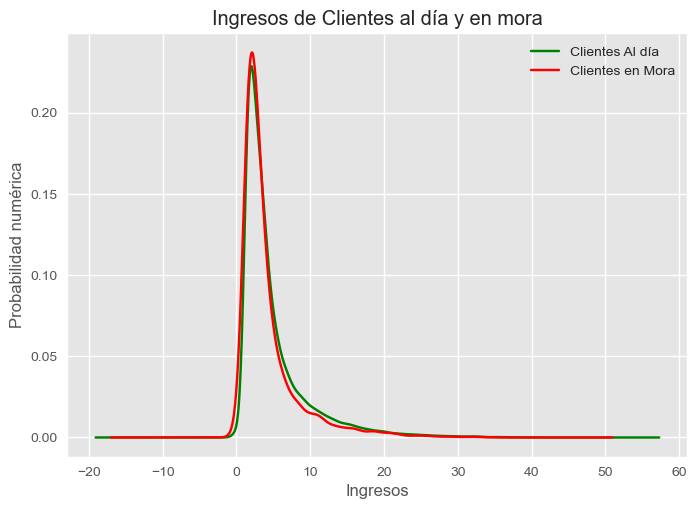

In [22]:
datos_0.INGRESO.plot.density(color='green',label='Clientes Al día') 
datos_1.INGRESO.plot.density(color='red',label='Clientes en Mora')
plt.legend()
plt.xlabel("Ingresos")
plt.ylabel('Probabilidad numérica')
plt.title('Ingresos de Clientes al día y en mora')

### Correlación

In [23]:
# Matriz de correlación compacta con encabezados verticales sin superposición
corr = datos.select_dtypes(include='number').corr().round(2)

display(
    corr.style
        .format("{:.2f}")
        .background_gradient(cmap="BrBG")
        # fuente y padding pequeños en todo
        .set_properties(**{"font-size":"8pt", "padding":"2px"})
        # estilos específicos de encabezados
        .set_table_styles([
            # columnas: vertical, ancho fijo pequeño, sin quiebre ni solape
            {"selector":"th.col_heading",
             "props":[
                 ("writing-mode","vertical-rl"),
                 ("text-orientation","mixed"),
                 ("width","24px"), ("min-width","24px"), ("max-width","24px"),
                 ("height","140px"),
                 ("white-space","nowrap"),
                 ("overflow","hidden"),
                 ("text-overflow","clip"),
                 ("font-size","7pt"),
                 ("padding","6px 2px")
             ]},
            # filas: fuente pequeña
            {"selector":"th.row_heading",
             "props":[("font-size","7pt"), ("white-space","nowrap")]}
        ])
)

,CLIENTE_MORA,EDAD,INGRESO,SCORE_DATACREDITO,ANT_SF,SALDO_SF,ULTIMAPERTURA,SALDO_FIJO,SALDO_ROT,ESTADO_MORA_FIN,ESTADO_MORA_REAL
CLIENTE_MORA,1.00,-0.04,-0.04,-0.27,-0.07,-0.01,-0.04,0.05,0.11,0.13,0.07
EDAD,-0.04,1.00,0.23,0.19,0.46,0.08,0.09,-0.00,-0.06,0.01,0.00
INGRESO,-0.04,0.23,1.00,0.16,0.47,0.70,-0.03,0.16,0.14,-0.02,-0.07
SCORE_DATACREDITO,-0.27,0.19,0.16,1.00,0.28,0.06,0.21,-0.20,-0.32,-0.36,-0.33
ANT_SF,-0.07,0.46,0.47,0.28,1.00,0.27,0.24,0.02,0.11,0.01,-0.03
SALDO_SF,-0.01,0.08,0.70,0.06,0.27,1.00,-0.07,0.18,0.16,-0.01,-0.06
ULTIMAPERTURA,-0.04,0.09,-0.03,0.21,0.24,-0.07,1.00,-0.14,0.04,0.06,0.02
SALDO_FIJO,0.05,-0.00,0.16,-0.20,0.02,0.18,-0.14,1.00,0.22,0.13,0.11
SALDO_ROT,0.11,-0.06,0.14,-0.32,0.11,0.16,0.04,0.22,1.00,0.06,-0.02
ESTADO_MORA_FIN,0.13,0.01,-0.02,-0.36,0.01,-0.01,0.06,0.13,0.06,1.00,0.79


* En la matriz de correlación se evidencia que las variables que más estan relacionadas con la variable de incumplimiento de pago es el score Advance generado por Datacredito y en segunda medida variables como los saldos de los creditos, los estados de mora y la antiguedad en el sector financiero. 


### Eliminación de variables VIF

In [24]:
# 1) Solo numéricas y limpieza mínima
num = datos.select_dtypes(include='number').copy()
num = num.dropna(axis=1, how='all')                 # quita columnas totalmente vacías
num = num.loc[:, num.nunique()>1]                   # quita columnas con varianza 0
num = num.fillna(num.median(numeric_only=True))     # imputación simple (si hay NA)

# 2) Matriz para VIF (no necesita estandarizar)
X = sm.add_constant(num, has_constant='add')

# 3) Calcular VIF (omitimos la constante en el resultado)
vif_vals = [variance_inflation_factor(X.values, i) for i in range(1, X.shape[1])]
vifs = (pd.DataFrame({'Variable': num.columns, 'VIF': vif_vals})
          .replace([np.inf, -np.inf], np.nan)
          .sort_values('VIF', ascending=False)
          .reset_index(drop=True))

# 4) Mostrar
display(vifs.style.format({'VIF':'{:.2f}'}))


,Variable,VIF
0,ESTADO_MORA_FIN,2.76
1,ESTADO_MORA_REAL,2.72
2,INGRESO,2.40
3,SALDO_SF,2.01
4,ANT_SF,1.75
5,SCORE_DATACREDITO,1.67
6,EDAD,1.29
7,SALDO_ROT,1.29
8,ULTIMAPERTURA,1.17
9,SALDO_FIJO,1.14


# Pipelines

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
import numpy as np
import pandas as pd

# X e y
X = datos.drop(columns='CLIENTE_MORA')
y = datos['CLIENTE_MORA']

# Detecta columnas
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# OneHotEncoder compatible (1.2-1.5+)
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # sklearn ≥1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)         # sklearn <1.2

preprocess = ColumnTransformer([
    ('num', RobustScaler(), num_cols),
    ('cat', ohe, cat_cols)
], remainder='drop')

X_pre = preprocess.fit_transform(X)
print(f"Shape original: {X.shape} → transformado: {X_pre.shape}")



Shape original: (40000, 13) → transformado: (40000, 17)


## Partición Train Test

In [26]:
from sklearn.model_selection import train_test_split

seed = 2025
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=seed, stratify=y, shuffle=True
)

# asegurar que preprocessing_pipeline exista
try:
    preprocessing_pipeline
except NameError:
    preprocessing_pipeline = preprocess

print(f"Split OK → X_train: {X_train.shape}, X_test: {X_test.shape}, seed={seed}")
print("preprocessing_pipeline definido ✅")




Split OK → X_train: (28000, 13), X_test: (12000, 13), seed=2025
preprocessing_pipeline definido ✅


## Funciones de evaluación

In [27]:
def evaluar_modelo(best_model, X_train, y_train, X_test, y_test, nombre="Modelo", pos_label=1):
    """Imprime métricas y devuelve un dict con resultados clave."""
    # Predicciones duras
    pred_train = best_model.predict(X_train)
    pred_test  = best_model.predict(X_test)

    # Probabilidades para AUC y PR-AUC
    if hasattr(best_model, "predict_proba"):
        proba_test = best_model.predict_proba(X_test)[:, 1]
    else:
        proba_test = best_model.decision_function(X_test)

    # Métricas
    train_acc    = accuracy_score(y_train, pred_train)
    test_acc     = accuracy_score(y_test,  pred_test)
    train_recall = recall_score(y_train, pred_train, pos_label=pos_label, zero_division=0)
    test_recall  = recall_score(y_test,  pred_test,  pos_label=pos_label, zero_division=0)
    train_prec   = precision_score(y_train, pred_train, pos_label=pos_label, zero_division=0)
    test_prec    = precision_score(y_test,  pred_test,  pos_label=pos_label, zero_division=0)
    roc_test     = roc_auc_score(y_test, proba_test)
    pr_test      = average_precision_score(y_test, proba_test)

    # Reporte
    print(f"=== {nombre} ===")
    print('Train Accuracy  : ', train_acc)
    print('Test  Accuracy  : ', test_acc)
    print('Train Recall    : ', train_recall)
    print('Test  Recall    : ', test_recall)
    print('Train Precision : ', train_prec)
    print('Test  Precision : ', test_prec)
    print('ROC AUC (test)  : ', roc_test)

    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, pred_test))

    print('\nClassification Report:')
    print(classification_report(y_test, pred_test, zero_division=0))

    return {
        "train_acc":    train_acc,
        "test_acc":     test_acc,
        "train_recall": train_recall,
        "test_recall":  test_recall,
        "train_prec":   train_prec,
        "test_prec":    test_prec,
        "roc_auc":      roc_test
    }


# Definicion Hiperparámetros y CV

In [28]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

seed = globals().get('seed', 42)

param_grid = {
    "model": [DecisionTreeClassifier(random_state=seed)],
    "model__criterion": ["gini", "entropy"],
    "model__splitter": ["best", "random"],
    "model__max_leaf_nodes": [128, 256, 512, 1024],
    "model__max_depth": list(map(int, np.linspace(4, 16, 32)))
}

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
n_iter = 50


## Pipeline base (sin balanceo)

In [29]:
if not any(v not in globals() for v in ["X_train","X_test","y_train","y_test","preprocessing_pipeline"]):
    full_pipeline_steps = [
        ('preprocessing_pipeline', preprocessing_pipeline),
        ('model', DecisionTreeClassifier(random_state=seed))
    ]
    full_pipeline = Pipeline(steps=full_pipeline_steps)

    grid_base = RandomizedSearchCV(
        estimator=full_pipeline,
        param_distributions=param_grid,
        cv=kfold,
        scoring=scoring,
        n_jobs=-1,
        n_iter=n_iter,
        refit="AUC",
        random_state=seed
    )
    best_model_base = grid_base.fit(X_train, y_train)
    print(">> Mejor AUC (CV) – Base:", best_model_base.best_score_)

    # === Métricas adicionales: Recall y AUC en train y test ===
    est = best_model_base.best_estimator_

    # Predicciones duras
    pred_train = est.predict(X_train)
    pred_test  = est.predict(X_test)

    # Scores probabilísticos para AUC
    if hasattr(est, "predict_proba"):
        score_train = est.predict_proba(X_train)[:, 1]
        score_test  = est.predict_proba(X_test)[:, 1]
    else:
        score_train = est.decision_function(X_train)
        score_test  = est.decision_function(X_test)

else:
    print("⛔ Define X_train/X_test/y_train/y_test/preprocessing_pipeline antes de ejecutar esta celda.")


>> Mejor AUC (CV) – Base: 0.7671969907406059


## Undersampling dentro del CV

In [30]:
if not any(v not in globals() for v in ["X_train","X_test","y_train","y_test","preprocessing_pipeline"]):
    undersampler = RandomUnderSampler(random_state=seed)

    pipe_under = ImbPipeline(steps=[
        ('preprocessing_pipeline', preprocessing_pipeline),
        ('sampler', undersampler),
        ('model', DecisionTreeClassifier(random_state=seed))
    ])

    grid_under = RandomizedSearchCV(
        estimator=pipe_under,
        param_distributions=param_grid,
        cv=kfold,
        scoring=scoring,
        n_jobs=-1,
        n_iter=n_iter,
        refit="AUC",
        random_state=seed
    )

    best_model_under = grid_under.fit(X_train, y_train)
    print(">> Mejor AUC (CV) – Undersampling:", best_model_under.best_score_)
else:
    print("⛔ Define X_train/X_test/y_train/y_test/preprocessing_pipeline antes de ejecutar esta celda.")


>> Mejor AUC (CV) – Undersampling: 0.7613389613193509


## Oversampling dentro del CV

In [31]:
if not any(v not in globals() for v in ["X_train","X_test","y_train","y_test","preprocessing_pipeline"]):
    oversampler = RandomOverSampler(random_state=seed)

    pipe_over = ImbPipeline(steps=[
        ('preprocessing_pipeline', preprocessing_pipeline),
        ('sampler', oversampler),
        ('model', DecisionTreeClassifier(random_state=seed))
    ])

    grid_over = RandomizedSearchCV(
        estimator=pipe_over,
        param_distributions=param_grid,
        cv=kfold,
        scoring=scoring,
        n_jobs=-1,
        n_iter=n_iter,
        refit="AUC",
        random_state=seed
    )

    best_model_over = grid_over.fit(X_train, y_train)
    print(">> Mejor AUC (CV) – Oversampling:", best_model_over.best_score_)
else:
    print("⛔ Define X_train/X_test/y_train/y_test/preprocessing_pipeline antes de ejecutar esta celda.")


>> Mejor AUC (CV) – Oversampling: 0.7657847275004157


## SMOTE dentro del CV

In [32]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, roc_auc_score  # por si faltan

if not any(v not in globals() for v in ["X_train","X_test","y_train","y_test","preprocessing_pipeline"]):
    smote = SMOTE(random_state=seed, k_neighbors=5)  # puedes tunear k_neighbors

    pipe_smote = ImbPipeline(steps=[
        ('preprocessing_pipeline', preprocessing_pipeline),
        ('sampler', smote),
        ('model', DecisionTreeClassifier(random_state=seed))
    ])

    grid_smote = RandomizedSearchCV(
        estimator=pipe_smote,
        param_distributions=param_grid,
        cv=kfold,
        scoring=scoring,
        n_jobs=-1,
        n_iter=n_iter,
        refit="AUC",
        random_state=seed
    )

    best_model_smote = grid_smote.fit(X_train, y_train)
    print(">> Mejor AUC (CV) – SMOTE:", best_model_smote.best_score_)

    # Métricas rápidas (train/test) para Recall y AUC
    est = best_model_smote.best_estimator_
    pred_train = est.predict(X_train)
    pred_test  = est.predict(X_test)

    if hasattr(est, "predict_proba"):
        score_train = est.predict_proba(X_train)[:, 1]
        score_test  = est.predict_proba(X_test)[:, 1]
    else:
        score_train = est.decision_function(X_train)
        score_test  = est.decision_function(X_test)

    print(f"Train Recall: {recall_score(y_train, pred_train, zero_division=0):.4f} | "
          f"Train AUC: {roc_auc_score(y_train, score_train):.4f}")
    print(f"Test  Recall: {recall_score(y_test,  pred_test,  zero_division=0):.4f} | "
          f"Test  AUC:  {roc_auc_score(y_test,  score_test):.4f}")
else:
    print("⛔ Define X_train/X_test/y_train/y_test/preprocessing_pipeline antes de ejecutar esta celda.")

>> Mejor AUC (CV) – SMOTE: 0.7563124280655422
Train Recall: 0.7425 | Train AUC: 0.7622
Test  Recall: 0.7338 | Test  AUC:  0.7517


## Validaciones finales

In [33]:
# ===== 10. Validaciones finales (incluye SMOTE si existe) =====
from sklearn.metrics import (
    accuracy_score, recall_score, roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)
models_to_eval = []
if 'best_model_base'  in globals(): models_to_eval.append(("Árbol – Base (sin balanceo)", best_model_base.best_estimator_))
if 'best_model_under' in globals(): models_to_eval.append(("Árbol – Undersampling",        best_model_under.best_estimator_))
if 'best_model_over'  in globals(): models_to_eval.append(("Árbol – Oversampling",         best_model_over.best_estimator_))
if 'best_model_smote' in globals(): models_to_eval.append(("Árbol – SMOTE",                best_model_smote.best_estimator_))

if models_to_eval:
    metrics_map = {}
    for nombre, est in models_to_eval:
        metrics_map[nombre] = evaluar_modelo(est, X_train, y_train, X_test, y_test, nombre=nombre)

    # (opcional) dejar variables sueltas como antes:
    if 'best_model_base'  in globals(): metrics_base  = metrics_map["Árbol – Base (sin balanceo)"]
    if 'best_model_under' in globals(): metrics_under = metrics_map["Árbol – Undersampling"]
    if 'best_model_over'  in globals(): metrics_over  = metrics_map["Árbol – Oversampling"]
    if 'best_model_smote' in globals(): metrics_smote = metrics_map["Árbol – SMOTE"]
else:
    print("⛔ No hay modelos para evaluar. Ejecuta primero Base/Under/Over/SMOTE.")

=== Árbol – Base (sin balanceo) ===
Train Accuracy  :  0.9220714285714285
Test  Accuracy  :  0.9210833333333334
Train Recall    :  0.037693006357856496
Test  Recall    :  0.02863202545068929
Train Precision :  0.5684931506849316
Test  Precision :  0.46551724137931033
ROC AUC (test)  :  0.7670754772987289

Confusion Matrix:
[[11026    31]
 [  916    27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     11057
           1       0.47      0.03      0.05       943

    accuracy                           0.92     12000
   macro avg       0.69      0.51      0.51     12000
weighted avg       0.89      0.92      0.89     12000

=== Árbol – Undersampling ===
Train Accuracy  :  0.6384642857142857
Test  Accuracy  :  0.6330833333333333
Train Recall    :  0.7833787465940054
Test  Recall    :  0.777306468716861
Train Precision :  0.1517016973001495
Test  Precision :  0.1488022736500203
ROC AUC (test)  :  0.762737644737080

In [34]:
metrics_base

{'train_acc': 0.9220714285714285,
 'test_acc': 0.9210833333333334,
 'train_recall': 0.037693006357856496,
 'test_recall': 0.02863202545068929,
 'train_prec': 0.5684931506849316,
 'test_prec': 0.46551724137931033,
 'roc_auc': 0.7670754772987289}

## Escoger el mejor modelo y extraer el árbol final

In [35]:
candidatos = []

if 'best_model_base'  in globals() and 'metrics_base'  in globals():
    candidatos.append(("base",  best_model_base,  metrics_base["test_recall"]))
if 'best_model_under' in globals() and 'metrics_under' in globals():
    candidatos.append(("under", best_model_under, metrics_under["test_recall"]))
if 'best_model_over'  in globals() and 'metrics_over'  in globals():
    candidatos.append(("over",  best_model_over,  metrics_over["test_recall"]))
if 'best_model_smote' in globals() and 'metrics_smote' in globals():
    candidatos.append(("smote", best_model_smote, metrics_smote["test_recall"]))

if candidatos:
    mejor_nombre, best_model, best_rec = max(candidatos, key=lambda x: x[2])
    print(f"\n>>> Mejor enfoque según Recall (test): {mejor_nombre.upper()} con Recall={best_rec:.4f}")
    dt_model = best_model.best_estimator_['model']
    print("\nHiperparámetros del árbol ganador:\n", dt_model.get_params())
else:
    print("⛔ No hay candidatos para comparar. Corre las celdas de entrenamiento/validación primero.")



>>> Mejor enfoque según Recall (test): UNDER con Recall=0.7773

Hiperparámetros del árbol ganador:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': 512, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 2025, 'splitter': 'best'}


## Curvas ROC y Precision-Recall del modelo ganador

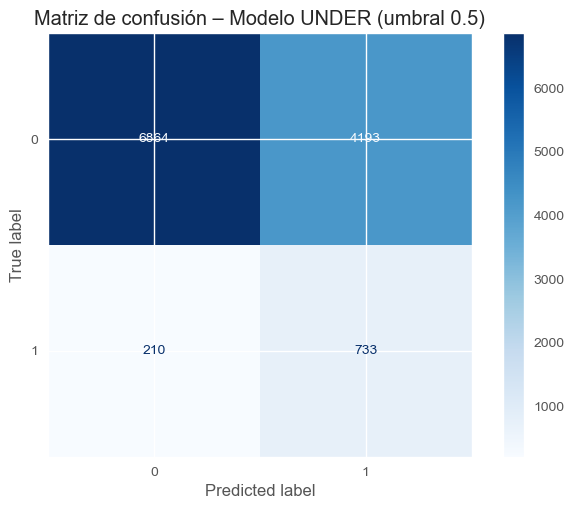

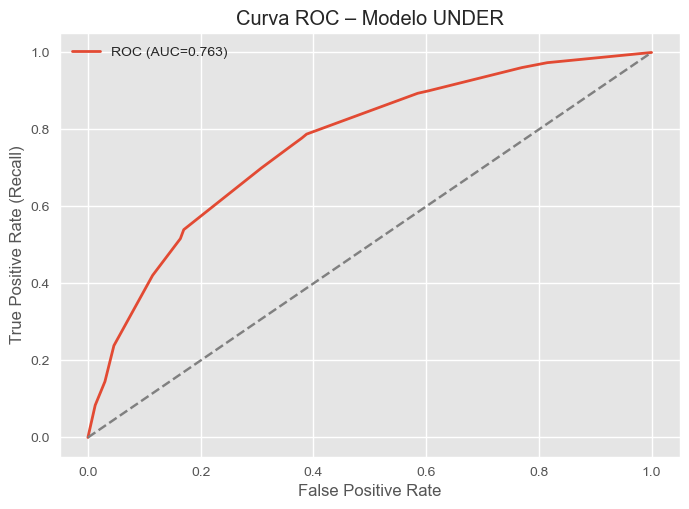

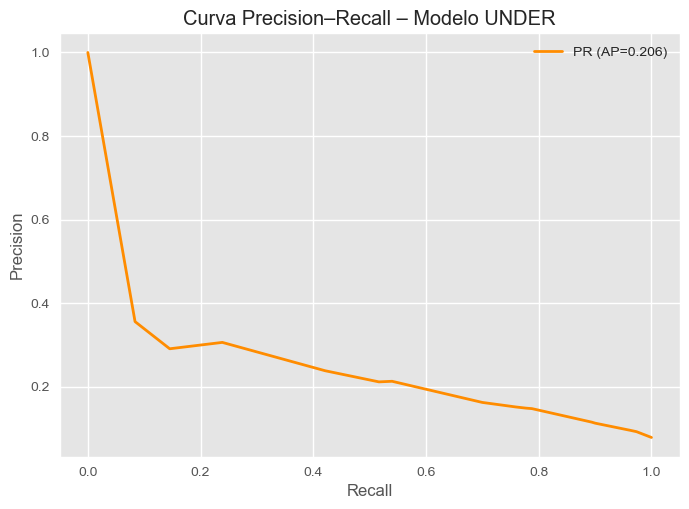

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

# === Modelo ganador: best_model_under ===
best_est = best_model_under.best_estimator_

# Probabilidades y predicciones en test
y_proba = best_est.predict_proba(X_test)[:,1]
y_pred  = (y_proba >= 0.5).astype(int)

# === Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Matriz de confusión – Modelo UNDER (umbral 0.5)")
plt.show()

# === Curva ROC ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})", lw=2)
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Curva ROC – Modelo UNDER")
plt.legend()
plt.grid(True)
plt.show()

# === Curva Precision–Recall ===
prec, rec, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure()
plt.plot(rec, prec, label=f"PR (AP={ap:.3f})", lw=2, color="darkorange")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall – Modelo UNDER")
plt.legend()
plt.grid(True)
plt.show()


# **Modelo XGBOOST CON REGULARIZACION**

## Balanceo UNDER

In [37]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

under = RandomUnderSampler(sampling_strategy=1.0, random_state=seed)
X_train_under, y_train_under = under.fit_resample(X_train, y_train)

# Resúmenes
def resumen(y):
    c = y.value_counts().sort_index()
    p = y.value_counts(normalize=True).sort_index().mul(100).round(2)
    return pd.DataFrame({"count": c, "pct%": p})

print("UNDER aplicado")
print(f"Tamaño original   : {X_train.shape[0]} filas")
print(f"Tamaño balanceado : {X_train_under.shape[0]} filas\n")

print("Distribución original (conteo y %):")
display(resumen(y_train))

print("Distribución balanceada (conteo y %):")
display(resumen(y_train_under))


UNDER aplicado
Tamaño original   : 28000 filas
Tamaño balanceado : 4404 filas

Distribución original (conteo y %):


,count,pct%
CLIENTE_MORA,,
0,25798,92.14
1,2202,7.86


Distribución balanceada (conteo y %):


,count,pct%
CLIENTE_MORA,,
0,2202,50.0
1,2202,50.0


## XGBoost SIN regularización

In [38]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

xgb_base = Pipeline(steps=[
    ('prep', preprocessing_pipeline),
    ('clf', XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=0, reg_alpha=0,                # sin regularización
        eval_metric="auc", random_state=seed
    ))
])

xgb_base.fit(X_train_under, y_train_under)
metrics_xgb_base = evaluar_modelo(xgb_base, X_train_under, y_train_under, X_test, y_test, "XGB – Base (sin reg)")

=== XGB – Base (sin reg) ===
Train Accuracy  :  0.8894187102633969
Test  Accuracy  :  0.676
Train Recall    :  0.8932788374205268
Test  Recall    :  0.6998939554612937
Train Precision :  0.886435331230284
Test  Precision :  0.15474794841735054
ROC AUC (test)  :  0.7615345374604227

Confusion Matrix:
[[7452 3605]
 [ 283  660]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     11057
           1       0.15      0.70      0.25       943

    accuracy                           0.68     12000
   macro avg       0.56      0.69      0.52     12000
weighted avg       0.90      0.68      0.75     12000



## XGBoost con Ridge (L2: reg_lambda)

In [39]:
xgb_ridge = Pipeline(steps=[
    ('prep', preprocessing_pipeline),
    ('clf', XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=10, reg_alpha=0,               # Ridge
        eval_metric="auc", random_state=seed
    ))
])

xgb_ridge.fit(X_train_under, y_train_under)
metrics_xgb_ridge = evaluar_modelo(xgb_ridge, X_train_under, y_train_under, X_test, y_test, "XGB – Ridge (L2)")


=== XGB – Ridge (L2) ===
Train Accuracy  :  0.8335603996366939
Test  Accuracy  :  0.6821666666666667
Train Recall    :  0.8437783832879201
Test  Recall    :  0.7147401908801697
Train Precision :  0.82688028482421
Test  Precision :  0.15975349608912065
ROC AUC (test)  :  0.7634102895523256

Confusion Matrix:
[[7512 3545]
 [ 269  674]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.68      0.80     11057
           1       0.16      0.71      0.26       943

    accuracy                           0.68     12000
   macro avg       0.56      0.70      0.53     12000
weighted avg       0.90      0.68      0.76     12000



## XGBoost con Lasso (L1: reg_alpha)

In [40]:
xgb_lasso = Pipeline(steps=[
    ('prep', preprocessing_pipeline),
    ('clf', XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=0, reg_alpha=10,               # Lasso
        eval_metric="auc", random_state=seed
    ))
])

xgb_lasso.fit(X_train_under, y_train_under)
metrics_xgb_lasso = evaluar_modelo(xgb_lasso, X_train_under, y_train_under, X_test, y_test, "XGB – Lasso (L1)")



=== XGB – Lasso (L1) ===
Train Accuracy  :  0.7756584922797457
Test  Accuracy  :  0.6855833333333333
Train Recall    :  0.7856494096276113
Test  Recall    :  0.7242841993637328
Train Precision :  0.7702582368655387
Test  Precision :  0.16277407054337464
ROC AUC (test)  :  0.7708649607149918

Confusion Matrix:
[[7544 3513]
 [ 260  683]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.68      0.80     11057
           1       0.16      0.72      0.27       943

    accuracy                           0.69     12000
   macro avg       0.56      0.70      0.53     12000
weighted avg       0.90      0.69      0.76     12000



## XGBoost con Elastic Net (L1 + L2)

In [41]:
xgb_elastic = Pipeline(steps=[
    ('prep', preprocessing_pipeline),
    ('clf', XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=5, reg_alpha=5,                # Elastic Net
        eval_metric="auc", random_state=seed
    ))
])

xgb_elastic.fit(X_train_under, y_train_under)
metrics_xgb_elastic = evaluar_modelo(xgb_elastic, X_train_under, y_train_under, X_test, y_test, "XGB – Elastic Net")


=== XGB – Elastic Net ===
Train Accuracy  :  0.8047229791099001
Test  Accuracy  :  0.6824166666666667
Train Recall    :  0.8192552225249773
Test  Recall    :  0.7179215270413574
Train Precision :  0.7961165048543689
Test  Precision :  0.16035054476551397
ROC AUC (test)  :  0.7672688261185101

Confusion Matrix:
[[7512 3545]
 [ 266  677]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.68      0.80     11057
           1       0.16      0.72      0.26       943

    accuracy                           0.68     12000
   macro avg       0.56      0.70      0.53     12000
weighted avg       0.90      0.68      0.76     12000



## Comparación de métricas (Accuracy, Recall, Precision, AUC)

In [42]:
import pandas as pd

df_xgb = pd.DataFrame([
    {"Modelo": "XGB Base",        **metrics_xgb_base},
    {"Modelo": "XGB Ridge (L2)",  **metrics_xgb_ridge},
    {"Modelo": "XGB Lasso (L1)",  **metrics_xgb_lasso},
    {"Modelo": "XGB Elastic",     **metrics_xgb_elastic},
])
display(df_xgb)


,Modelo,train_acc,test_acc,train_recall,test_recall,train_prec,test_prec,roc_auc
0,XGB Base,0.889419,0.676000,0.893279,0.699894,0.886435,0.154748,0.761535
1,XGB Ridge (L2),0.833560,0.682167,0.843778,0.714740,0.826880,0.159753,0.763410
2,XGB Lasso (L1),0.775658,0.685583,0.785649,0.724284,0.770258,0.162774,0.770865
3,XGB Elastic,0.804723,0.682417,0.819255,0.717922,0.796117,0.160351,0.767269


## Curvas ROC comparativas (con AUC)

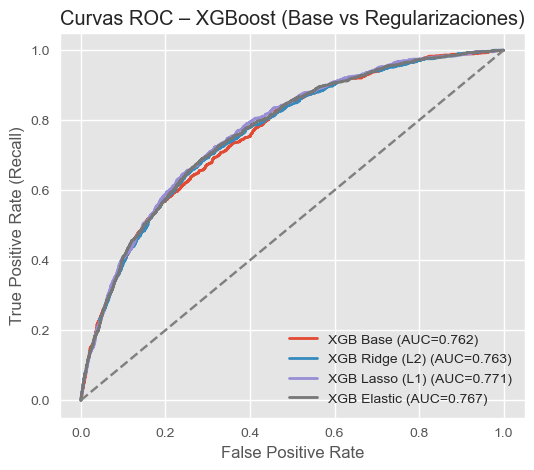

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(6,5))
for nombre, modelo in [
    ("XGB Base", xgb_base),
    ("XGB Ridge (L2)", xgb_ridge),
    ("XGB Lasso (L1)", xgb_lasso),
    ("XGB Elastic", xgb_elastic),
]:
    y_proba = modelo.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, lw=2, label=f"{nombre} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Curvas ROC – XGBoost (Base vs Regularizaciones)")
plt.legend()
plt.grid(True)
plt.show()


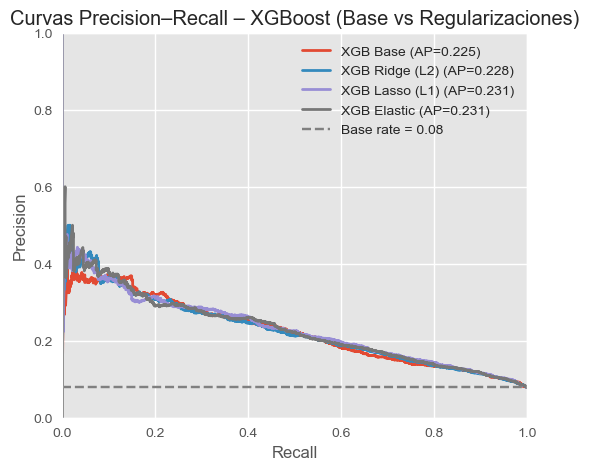

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(6,5))

for nombre, modelo in [
    ("XGB Base", xgb_base),
    ("XGB Ridge (L2)", xgb_ridge),
    ("XGB Lasso (L1)", xgb_lasso),
    ("XGB Elastic", xgb_elastic),
]:
    y_proba = modelo.predict_proba(X_test)[:, 1]
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    plt.plot(rec, prec, lw=2, label=f"{nombre} (AP={ap:.3f})")

# línea base: proporción positiva en test
pos_rate = (y_test == 1).mean()
plt.hlines(pos_rate, 0, 1, linestyles='--', colors='gray', label=f"Base rate = {pos_rate:.2f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precision–Recall – XGBoost (Base vs Regularizaciones)")
plt.legend()
plt.grid(True)
plt.xlim(0, 1); plt.ylim(0, 1)
plt.show()


In [45]:
# Elegir mejores modelos por AUC y por Recall (test)
candidatos = [
    ("XGB Base",    xgb_base,    metrics_xgb_base),
    ("XGB Ridge",   xgb_ridge,   metrics_xgb_ridge),
    ("XGB Lasso",   xgb_lasso,   metrics_xgb_lasso),
    ("XGB Elastic", xgb_elastic, metrics_xgb_elastic),
]

# Mejor por AUC
mejor_auc_nombre, mejor_auc_modelo, mejor_auc_score = max(
    ((n, m, met["roc_auc"]) for n, m, met in candidatos),
    key=lambda t: t[2]
)

# Mejor por Recall (test)
mejor_rec_nombre, mejor_rec_modelo, mejor_rec_score = max(
    ((n, m, met["test_recall"]) for n, m, met in candidatos),
    key=lambda t: t[2]
)

print(f">>> Mejor por AUC     : {mejor_auc_nombre}  | AUC={mejor_auc_score:.4f}")
print(f">>> Mejor por Recall  : {mejor_rec_nombre} | Recall={mejor_rec_score:.4f}")

# (Opcional) hiperparámetros internos del clasificador ganador en cada criterio
print("\nHiperparámetros – ganador por AUC:")
print(mejor_auc_modelo.named_steps['clf'].get_params())

print("\nHiperparámetros – ganador por Recall:")
print(mejor_rec_modelo.named_steps['clf'].get_params())

# (Opcional) dejar variables de salida para usar después
best_by_auc     = {"nombre": mejor_auc_nombre, "modelo": mejor_auc_modelo, "score": mejor_auc_score}
best_by_recall  = {"nombre": mejor_rec_nombre, "modelo": mejor_rec_modelo, "score": mejor_rec_score}



>>> Mejor por AUC     : XGB Lasso  | AUC=0.7709
>>> Mejor por Recall  : XGB Lasso | Recall=0.7243

Hiperparámetros – ganador por AUC:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'auc', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 2025, 'reg_alpha': 10, 'reg_lambda': 0, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 

# Código completo XGBOOST con Undersampling y Regularización L1, cross_validation y Optimización del umbral.

In [46]:
# ===============================================
# 1️⃣ BALANCEO DE CLASES (UNDERSAMPLING)
# ===============================================
from imblearn.under_sampling import RandomUnderSampler

# Se iguala la cantidad de clases para evitar sesgo hacia la clase mayoritaria
under = RandomUnderSampler(sampling_strategy=1.0, random_state=seed)
X_train_under, y_train_under = under.fit_resample(X_train, y_train)

# Mostrar tamaños y proporciones
print("UNDER aplicado correctamente ✅")
print(f"Tamaño original: {X_train.shape[0]} filas")
print(f"Tamaño balanceado: {X_train_under.shape[0]} filas\n")

print("Distribución original:")
print(y_train.value_counts())
print("\nDistribución balanceada:")
print(y_train_under.value_counts())

UNDER aplicado correctamente ✅
Tamaño original: 28000 filas
Tamaño balanceado: 4404 filas

Distribución original:
CLIENTE_MORA
0    25798
1     2202
Name: count, dtype: int64

Distribución balanceada:
CLIENTE_MORA
0    2202
1    2202
Name: count, dtype: int64


In [47]:
# ===============================================
# 2️⃣ MODELO XGBOOST CON REGULARIZACIÓN LASSO (L1)
# ===============================================
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Regularización L1 se controla con reg_alpha > 0
xgb_lasso = Pipeline(steps=[
    ('prep', preprocessing_pipeline),
    ('clf', XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=0, reg_alpha=10,               # Lasso (L1)
        eval_metric="auc", random_state=seed
    ))
])

print("Modelo XGBoost con regularización L1 configurado ✅")

Modelo XGBoost con regularización L1 configurado ✅


In [48]:
# ===============================================
# 3️⃣ VALIDACIÓN CRUZADA (STRATIFIED K-FOLD)
# ===============================================
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score
import numpy as np

# Se define validación cruzada estratificada (mantiene proporciones de clases)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Vector para guardar probabilidades OOF (out-of-fold)
oof_proba = np.zeros(len(y_train_under), dtype=float)

for tr_idx, va_idx in cv.split(X_train_under, y_train_under):
    xtr, xva = X_train_under.iloc[tr_idx], X_train_under.iloc[va_idx]
    ytr, yva = y_train_under.iloc[tr_idx], y_train_under.iloc[va_idx]
    
    xgb_lasso.fit(xtr, ytr)
    oof_proba[va_idx] = xgb_lasso.predict_proba(xva)[:, 1]

# Calcular AUC promedio de la validación cruzada
auc_cv = roc_auc_score(y_train_under, oof_proba)
ap_cv  = average_precision_score(y_train_under, oof_proba)

print(f"AUC promedio CV: {auc_cv:.3f}")
print(f"Average Precision (PR-AUC) CV: {ap_cv:.3f}")

AUC promedio CV: 0.766
Average Precision (PR-AUC) CV: 0.750


In [49]:
# ===============================================
# 4️⃣ OPTIMIZACIÓN DEL UMBRAL (THRESHOLD)
# ===============================================
from sklearn.metrics import f1_score

# Calculamos curva Precision-Recall
prec, rec, thr = precision_recall_curve(y_train_under, oof_proba)
f1 = 2 * prec * rec / (prec + rec + 1e-12)
thr_candidates = np.r_[thr, 1.0]  # Alinear longitudes

# Seleccionamos el umbral que maximiza el F1
idx_opt = np.nanargmax(f1)
thr_opt = float(thr_candidates[idx_opt])

print(f"Umbral óptimo seleccionado: {thr_opt:.3f}")
print(f"F1 óptimo: {f1[idx_opt]:.3f} | Precisión: {prec[idx_opt]:.3f} | Recall: {rec[idx_opt]:.3f}")

Umbral óptimo seleccionado: 0.360
F1 óptimo: 0.731 | Precisión: 0.640 | Recall: 0.853


In [50]:
# ===============================================
# 5️⃣ REENTRENAMIENTO Y EVALUACIÓN FINAL EN TEST
# ===============================================

# Entrenamos el modelo con todos los datos balanceados
xgb_lasso.fit(X_train_under, y_train_under)

# Calculamos probabilidades y predicciones en Test con el umbral óptimo
proba_test = xgb_lasso.predict_proba(X_test)[:, 1]
pred_test  = (proba_test >= thr_opt).astype(int)

# Evaluamos con la función definida previamente
metrics_xgb_lasso_opt = evaluar_modelo(xgb_lasso, X_train_under, y_train_under, X_test, y_test, nombre="XGBoost Lasso (L1) – Threshold Óptimo")

=== XGBoost Lasso (L1) – Threshold Óptimo ===
Train Accuracy  :  0.7756584922797457
Test  Accuracy  :  0.6855833333333333
Train Recall    :  0.7856494096276113
Test  Recall    :  0.7242841993637328
Train Precision :  0.7702582368655387
Test  Precision :  0.16277407054337464
ROC AUC (test)  :  0.7708649607149918

Confusion Matrix:
[[7544 3513]
 [ 260  683]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.68      0.80     11057
           1       0.16      0.72      0.27       943

    accuracy                           0.69     12000
   macro avg       0.56      0.70      0.53     12000
weighted avg       0.90      0.69      0.76     12000

